# Excercises 

## 0. Setup your own repo
- Dont work in this repo. This is my material for lessons. Set up your own repo to work in. Use `MADS-ML-{yourname}` as a format, eg `MADS-ML-JoostB`.
- You can add `mads_datasets` and `mltrainer` as dependencies to your own repo, in addition to more basic things like jupyter, torch and seaborn.
- If you want to use the tomlserializer, add `tomlserializer` as a dependency. For tensorboard, add `tensorboard` and `torch-tb-profiler`.
- Invite me (raoulg; https://github.com/raoulg) as a collaborator to your repo.

# 1. Tune the network
Run the experiment below, explore the different parameters (see suggestions below) and study the result with tensorboard. 
Make a single page (1 a4) report of your findings. Use your visualisation skills to communicate your most important findings.

In [2]:
from mads_datasets import DatasetFactoryProvider, DatasetType

from mltrainer.preprocessors import BasePreprocessor
from mltrainer import imagemodels, Trainer, TrainerSettings, ReportTypes, metrics

import torch.optim as optim
from torch import nn
from tomlserializer import TOMLSerializer

We will be using `tomlserializer` to easily keep track of our experiments, and to easily save the different things we did during our experiments.
It can export things like settings and models to a simple `toml` file, which can be easily shared, checked and modified.

First, we need the data. 

In [3]:
fashionfactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
preprocessor = BasePreprocessor()
streamers = fashionfactory.create_datastreamer(batchsize=64, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
trainstreamer = train.stream()
validstreamer = valid.stream()

2025-05-05 19:52:19.934 | INFO     | mads_datasets.base:download_data:94 - Start download...
  0%|          | 0.00/55.4M [00:00<?, ?iB/s]2025-05-05 19:52:22.801 | INFO     | mads_datasets.datatools:get_file:105 - Downloading /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt
100%|██████████| 55.4M/55.4M [00:00<00:00, 64.1MiB/s]
2025-05-05 19:52:23.791 | INFO     | mads_datasets.base:download_data:112 - Digest of /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt matches expected digest


We need a way to determine how well our model is performing. We will use accuracy as a metric.

In [11]:
accuracy = metrics.Accuracy()

You can set up a single experiment.

- We will show the model batches of 64 images, 
- and for every epoch we will show the model 100 batches (trainsteps=100).
- then, we will test how well the model is doing on unseen data (teststeps=100).
- we will report our results during training to tensorboard, and report all configuration to a toml file.
- we will log the results into a directory called "modellogs", but you could change this to whatever you want.

In [5]:
import torch
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=100,
    valid_steps=100,
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)


2025-05-05 19:52:23.848 | INFO     | mltrainer.settings:check_path:60 - Created logdir /home/azureuser/mllabs/MADS-ML-Morris/notebooks/1_pytorch_intro/modellogs


We will use a very basic model: a model with three linear layers.

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_classes: int, units1: int, units2: int) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.units1 = units1
        self.units2 = units2
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, units1),
            nn.ReLU(),
            nn.Linear(units1, units2),
            nn.ReLU(),
            nn.Linear(units2, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork(
    num_classes=10, units1=256, units2=256)

I developped the `tomlserializer` package, it is a useful tool to save configs, models and settings as a tomlfile; that way it is easy to track what you changed during your experiments.

In [7]:
tomlserializer = TOMLSerializer()
tomlserializer.save(settings, "settings.toml")
tomlserializer.save(model, "model.toml")

Check the `settings.toml` and `model.toml` files to see what is in there.

You can use the `Trainer` class from my `mltrainer` module to train your model. It has the TOMLserializer integrated, so it will automatically save the settings and model to a toml file if you have added `TOML` as a reporttype in the settings.

In [8]:
trainer = Trainer(
    model=model,
    settings=settings,
    loss_fn=loss_fn,
    optimizer=optim.Adam,
    traindataloader=trainstreamer,
    validdataloader=validstreamer,
    scheduler=optim.lr_scheduler.ReduceLROnPlateau
)
trainer.loop()

2025-05-05 19:52:23.903 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250505-195223
2025-05-05 19:52:28.991 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 100/100 [00:00<00:00, 113.60it/s]
2025-05-05 19:52:30.600 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.9452 test 0.6853 metric ['0.7470']
100%|██████████| 100/100 [00:00<00:00, 123.62it/s]
2025-05-05 19:52:31.930 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.5908 test 0.5453 metric ['0.8059']
100%|██████████| 100/100 [00:00<00:00, 103.25it/s]
2025-05-05 19:52:33.373 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.5268 test 0.5473 metric ['0.8080']
2025-05-05 19:52:33.375 | INFO     | mltrainer.trainer:__call__:248 - best loss: 0.5453, current loss 0.5473.Counter 1/10.
100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Now, check in the modellogs directory the results of your experiment.

We can now loop this with a naive approach, called a grid-search (why do you think i call it naive?).

In [9]:
units = [256, 128, 64]
for unit1 in units:
    for unit2 in units:
        print(f"Units: {unit1}, {unit2}")

Units: 256, 256
Units: 256, 128
Units: 256, 64
Units: 128, 256
Units: 128, 128
Units: 128, 64
Units: 64, 256
Units: 64, 128
Units: 64, 64


Of course, this might not be the best way to search for a model; some configurations will be better than others (can you predict up front what will be the best configuration?).

So, feel free to improve upon the gridsearch by adding your own logic.

In [10]:
import torch

units = [256, 128, 64]
loss_fn = torch.nn.CrossEntropyLoss()

settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellogs",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.TOML],
)

for unit1 in units:
    for unit2 in units:

        model = NeuralNetwork(num_classes=10, units1=unit1, units2=unit2)

        trainer = Trainer(
            model=model,
            settings=settings,
            loss_fn=loss_fn,
            optimizer=optim.Adam,
            traindataloader=trainstreamer,
            validdataloader=validstreamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()


2025-05-05 19:52:33.417 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250505-195233
2025-05-05 19:52:33.419 | INFO     | mltrainer.trainer:__init__:68 - Found earlystop_kwargs in settings.Set to None if you dont want earlystopping.
100%|██████████| 937/937 [00:07<00:00, 120.13it/s]
2025-05-05 19:52:41.932 | INFO     | mltrainer.trainer:report:205 - Epoch 0 train 0.5091 test 0.4061 metric ['0.8513']
100%|██████████| 937/937 [00:08<00:00, 114.99it/s]
2025-05-05 19:52:50.858 | INFO     | mltrainer.trainer:report:205 - Epoch 2 train 0.3687 test 0.3974 metric ['0.8527']
100%|██████████| 937/937 [00:09<00:00, 98.82it/s] 
2025-05-05 19:53:01.328 | INFO     | mltrainer.trainer:report:205 - Epoch 4 train 0.3316 test 0.3856 metric ['0.8607']
100%|██████████| 3/3 [00:27<00:00,  9.30s/it]
2025-05-05 19:53:01.336 | INFO     | mltrainer.trainer:dir_add_timestamp:24 - Logging to modellogs/20250505-195301
2025-05-05 19:53:01.337 | INFO     | mltrainer.trainer:__init__:68

Because we have set the ReportType to TOML, you will find in every log dir a model.toml and settings.toml file.

Run the experiment, and study the result with tensorboard. 

Locally, it is easy to do that with VS code itself. On the server, you have to take these steps:

- in the terminal, `cd` to the location of the repository
- activate the python environment for the shell. Note how the correct environment is being activated.
- run `tensorboard --logdir=modellogs` in the terminal
- tensorboard will launch at `localhost:6006` and vscode will notify you that the port is forwarded
- you can either press the `launch` button in VScode or open your local browser at `localhost:6006`


# Report
## 1. experiment
Experiment with things like:
- change the number of epochs, eg to 5 or 10. 
- changing the amount of units1 and units2 to values between 16 and 1024. Use factors of 2 to easily scan the ranges: 16, 32, 64, etc.
- changing the batchsize to values between 4 and 128. Again, use factors of two for convenience.
- change the depth of your model by adding a additional linear layer + activation function
- changing the learningrate to values between 1e-2 and 1e-5 
- changing the optimizer from SGD to one of the other available algoritms at [torch](https://pytorch.org/docs/stable/optim.html) (scroll down for the algorithms)

Check the results:
- all your experiments are saved in the `modellogs` directory, with a timestamp. Inside you find a model.toml file, that 
contains all the settings of the model. The `events` file is what tensorboard will show.
- visualize the relationship between variables: for example, make a heatmap of units vs layers.

Studyquestions:
- Epochs: what is the upside, what is the downside of increasing epochs? Do you need more epochs to find out which configuration is best? When do you need that, when not?
- what is an upside of using factors of 2 for hypertuning? What is a downside?

## Note
A note on train_steps: this is a setting that determines how often you get an update. 
Because our complete dataset is 938 (60000 / 64) batches long, you will need 938 trainstep to cover the complete 60.000 images.

This can actually be a bit confusion for some students, because changing the value of trainsteps 938 changes the meaning of an `epoch` slightly, because one epoch is no longer the full dataset, but simply `trainstep` batches. Setting trainsteps to 100 means you need to wait twice as long before you get feedback on the performance, as compared to trainsteps=50. You will see that settings trainsteps to 100 improves the learning, but that is simply because the model has seen twice as much examples as compared to trainsteps=50.

This implies that it is not usefull to compare trainsteps=50 and trainsteps=100, because setting it to 100 will always be better.
Just pick an amount that works for your hardware & patience, and adjust your number of epochs accordingly (increase epochs with lower values for trainsteps)

# 2. Reflect
Doing a master means you don't just start engineering a pipeline, but you need to reflect. Why do you see the results you see? What does this mean, considering the theory? Write down lessons learned and reflections, based on experimental results. This is the `science` part of `data science`.

You follow this cycle:
- make a hypothesis
- design an experiment
- run the experiment
- analyze the results and draw conclusions
- repeat

## Tip
To keep track of this process, it is useful to keep a journal. While you could use anything to do so, a nice command line tool is [jrnl](https://jrnl.sh/en/stable/). This gives you the advantage of staying in the terminal, just type down your ideas during the process, and you can always look back at what you have done.
Try to first formulate a hypothesis, and then design an experiment to test it. This will help you to stay focused on the goal, and not get lost in the data.

Important: the report you write is NOT the same as your journal! The journal will help you to keep track of your process, and later write down a reflection on what you have done where you draw conclusion, reflecting back on the theory.

# 3. Make a short report
Make a short 1 a4 page report of your findings.
pay attention to:
- what was your hypothesis about interaction between hyperparameters?
- what did you find?
- visualise your results about the relationship between hyperparameters.


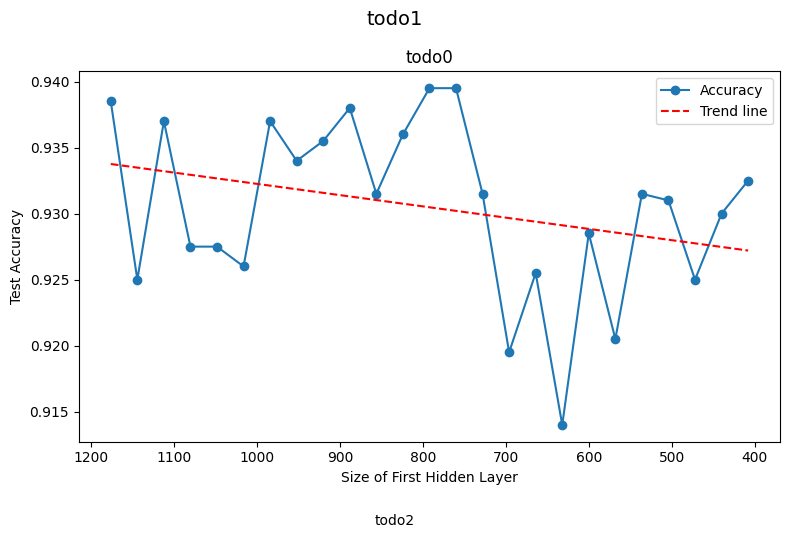

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt

# Set up MNIST data loading
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='data', train=False, transform=transform)

train_subset = Subset(train_data, random.sample(range(len(train_data)), 10_000))
test_subset = Subset(test_data, random.sample(range(len(test_data)), 2_000))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64)

# Define model factory
class CustomNet(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, hidden1_size),
            nn.ReLU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, output_size)
        )

    def forward(self, x):
        return self.net(x)

# Training function
def train_model(model, train_loader, loss_fn, optimizer, epochs=5):
    model.train()
    for _ in range(epochs):
        for X, y in train_loader:
            pred = model(X)
            loss = loss_fn(pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in test_loader:
            pred = model(X)
            predicted = pred.argmax(dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    return correct / total

# Experiment parameters
input_size = 28 * 28
hidden_layer2_size = 64
hidden_layer3_size = 32
output_size = 10
step_size = 32

start_size = int(1.5 * input_size)
end_size = int(0.5 * input_size)

hidden_sizes = list(range(start_size, end_size - 1, -step_size))  # descending
accuracies = []

# # Run experiment
# for hidden1_size in hidden_sizes:
#     model = CustomNet(input_size, hidden1_size, hidden_layer2_size, hidden_layer3_size, output_size)
#     loss_fn = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#     train_model(model, train_loader, loss_fn, optimizer, epochs=2)
#     acc = evaluate_model(model, test_loader)
#     print(f"Hidden1 size {hidden1_size}: Accuracy = {acc:.4f}")
#     accuracies.append(acc)


# Actual data
hidden_sizes = [
    1176, 1144, 1112, 1080, 1048, 1016, 984, 952, 920, 888,
    856, 824, 792, 760, 728, 696, 664, 632, 600, 568,
    536, 504, 472, 440, 408
]

accuracies = [
    0.9385, 0.9250, 0.9370, 0.9275, 0.9275, 0.9260, 0.9370, 0.9340, 0.9355, 0.9380,
    0.9315, 0.9360, 0.9395, 0.9395, 0.9315, 0.9195, 0.9255, 0.9140, 0.9285, 0.9205,
    0.9315, 0.9310, 0.9250, 0.9300, 0.9325
]
# Visualization
import matplotlib.pyplot as plt
import numpy as np

# Assume `hidden_sizes` and `accuracies` are already defined

# Fit a linear trend line
z = np.polyfit(hidden_sizes, accuracies, 1)
p = np.poly1d(z)
trend_y = p(hidden_sizes)

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 5))

# Plot accuracy points
ax.plot(hidden_sizes, accuracies, marker='o', label='Accuracy')

# Plot trend line
ax.plot(hidden_sizes, trend_y, linestyle='--', color='red', label='Trend line')

# Styling
ax.set_xlabel('Size of the first hidden layer')
ax.set_ylabel('Accuracy')
ax.set_title('todo0')  # Main title
ax.legend()

# Add super title and subtitle
fig.suptitle('todo1', fontsize=14)
fig.text(0.5, -0.05, 'Input size of 784', ha='center', fontsize=10)

# Remove grid lines
ax.grid(False)

# Optional: reverse X axis for visual clarity
ax.invert_xaxis()

plt.tight_layout()
plt.show()
